# Manual Implementation of Dropout in a Multilayer Artificial Neural Network using the PyTorch Library.







In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy.random import random
import pandas as pd
import datetime
import time
from torch import optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.cuda.is_available()

True

 In this notebook, we manually implement the Dropout method in a neural network using the PyTorch library. Additionally, three distinct models are trained. The first model is a neural network with a single intermediate layer, without dropout. The second model is identical to the first but incorporates dropout between the intermediate layer and the output layer, this implementation uses PyTorch's built-in nn.Module class for dropout. Finally, a third model is trained, this time with a manual implementation of dropout.

 The purpose of training three diverse models is to facilitate result comparison. The models are trained using the MNIST dataset.







### First Model, No DropOut

In [ ]:
class Net(nn.Module):
    def __init__(self,n):
        super(Net,self).__init__()
        self.flatten = nn.Flatten()
        self.layer_one = nn.Linear(784,n)
        #self.layer_two = nn.Linear(512,512)
        self.relu = nn.ReLU()
        self.layer_out = nn.Linear(n,10)

    def nombre(self):
        return 'SinDropout'

    def forward(self,x):
        x = self.flatten(x)
        x = self.layer_one(x)
       # x = self.layer_two(x)
        x = self.relu(x)
        x = self.layer_out(x)
        return x

In [ ]:
x=torch.randn(1, 784)


In [ ]:
model = Net(512)  #verifico que el modelo pueda predecir un input.
model(x)

tensor([[-0.1906,  0.0036,  0.3999,  0.0123, -0.3553,  0.1158,  0.1469,  0.1425,
         -0.1950,  0.0335]], grad_fn=<AddmmBackward0>)

In [ ]:
model.nombre()

'SinDropout'

### Second Model with Dropout Implemented Using the nn.Dropout Class

In [ ]:
class DropOut(nn.Module):
    def __init__(self,p,n):
        super(DropOut,self).__init__()
        self.flatten = nn.Flatten()
        self.layer_one = nn.Linear(784,n)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)
        self.layer_out = nn.Linear(n,10)

    def nombre(self):
        return 'DropOut'

    def forward(self,x):
        x = self.flatten(x)
        x = self.layer_one(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

In [ ]:
model2=DropOut(0.8,512)

In [ ]:
model2.nombre()

'DropOut'

In [ ]:
x = torch.randn(1,784)
model2(x)

tensor([[ 1.0105,  0.6668,  0.1412,  0.8311, -0.3836, -1.1857, -0.2723,  0.2841,
         -0.8800, -0.2208]], grad_fn=<AddmmBackward0>)

### Manual Implementation of Dropout within the forward() Method in PyTorch.

In [ ]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape).to(device) >= dropout).float()
    #mask = torch.rand(X.shape) >= dropout   #esto no sirve xq tira a los elementos con False, no les asigna 0
    return mask*X / (1.0 - dropout)

In [ ]:
X = torch.randn(64,784)

In [ ]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
X= X.to(device)
#X = torch.randn(64,728)
print(X)
%time print('dropout_p = 0:', dropout_layer(X, 0))
%time print('dropout_p = 0.5:', dropout_layer(X, 0.5))
%time print('dropout_p = 1:', dropout_layer(X, 1))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]], device='cuda:0')
dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]], device='cuda:0')
CPU times: user 3.26 ms, sys: 73 µs, total: 3.33 ms
Wall time: 3.26 ms
dropout_p = 0.5: tensor([[ 0.,  0.,  0.,  6.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 22., 24.,  0.,  0., 30.]], device='cuda:0')
CPU times: user 1.64 ms, sys: 889 µs, total: 2.53 ms
Wall time: 2.43 ms
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
CPU times: user 1.87 ms, sys: 0 ns, total: 1.87 ms
Wall time: 4.82 ms


In [ ]:
class ManualDropOut(nn.Module):
    def __init__(self,p,n):
        super(ManualDropOut,self).__init__()
        self.p = p
        self.n = n
        self.flatten = nn.Flatten()
        self.layer_one = nn.Linear(784,self.n)
        self.relu = nn.ReLU()
        self.layer_out = nn.Linear(self.n,10)

    def nombre(self):
        return 'ManualDropOut'

    def forward(self,x):
        x = self.flatten(x)
        x = self.layer_one(x)
        x = self.relu(x)
        if self.training:
            x = dropout_layer(x,self.p)
        x = self.layer_out(x)
        return x

In [ ]:
x = torch.randn(1,784).to(device)
modelo = ManualDropOut(0.5,512)
modelo.to(device)
modelo(x)

tensor([[-0.1966,  0.4632,  0.0923, -0.0850, -0.3226,  0.1682,  0.0313, -0.4551,
          0.6775,  0.6968]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
def prueba(model):
    return model.nombre()

In [ ]:
prueba(modelo)

'ManualDropOut'

# Training, Validation, and Testing

### Below, the necessary code blocks are defined to execute the training and validation process.

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    model.to(device)
    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        X=X.to(device)
        y=y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Imprimimos el progreso...
        # if batch % 100 == 0:
           # loss, current = loss.item(), batch * len(X)
            #print(f"batch={batch} loss={loss:>7f}  muestras-procesadas:[{current:>5d}/{size:>5d}]")

# De manera similar, definimos la función de testeo, que se usara tambien para validar.
def test_loop(dataloader,model,loss_fn):
    num_samples  = 0
    num_batches  = 0
    avrg_loss    = 0
    frac_correct = 0
    # Seteamos el modelo en modo evaluacion. Esto sirve para desactivar, por ejemplo, dropout, etc. cuando no estamos en una fase de entrenamiento.
    model.eval()
    # Pasamos el modelo la GPU si está disponible.
    model = model.to(device)
    # Para validar, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        for X,y in dataloader:
            # Pasamos los tensores a la GPU si está disponible.
            X = X.to(device)
            y = y.to(device)
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            num_batches += 1
            avrg_loss += loss_fn(pred,y).item() #el item va para convertir la loss de tensor a escalar
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            num_samples += y.size(0)
            frac_correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avrg_loss    /= num_batches
    frac_correct /= num_samples
    #print(f"Test Error: \n Accuracy: {frac_correct:>0.5f}, Avg. loss: {avrg_loss:>8f} \n")
    return avrg_loss,frac_correct

In [ ]:
# Definimos hiperparámetros de entrenamiento
batch_size = 64
num_epochs = 40
lr =[0.1,0.01,0.001]
def train_validation(model,train_dataloader,valid_dataloader,df):
  for learning_rate in lr:
    # Creamos el modelo y el optimzador
    modelo = DropOut(0.2,512)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(modelo.parameters(),lr=learning_rate)
    # Entrenamos el modelo y calcualmos curvas.
    min_valid_loss = float("inf")
    for epoch in range(num_epochs):
        train_loop(train_dataloader,modelo,loss_fn,optimizer)
        train_loss,train_accu = test_loop(train_dataloader,modelo,loss_fn)
        valid_loss,valid_accu = test_loop(valid_dataloader,modelo,loss_fn)
        print(f"lr={learning_rate} epoch={epoch} train_loss={train_loss} train_accu={train_accu} valid_loss={valid_loss} valid_accu={valid_accu}")
        df = df.append({"Lr":learning_rate,
                         "epoch":epoch,
                         "train_loss":train_loss,
                         "train_accu":train_accu,
                          "valid_loss":valid_loss,
                          "valid_accu":valid_accu,
                        "model"     :model.nombre()}
                       ,ignore_index=True)
  return df

### Loading Dataset

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 107271672.62it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 115147997.93it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45498088.19it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4211923.23it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Before running the models, a test is conducted using a single sample from the training and validation sets to verify that everything is functioning correctly.

#### I define the Dataset class, which allows me to manipulate the data used to feed the models.

In [ ]:
class Dataset(torch.utils.data.Dataset):
    # constructor
    def __init__(self, X, Y):
        self.X = X
        self.Y = torch.tensor(Y)
    # devolvemos el número de datos en el dataset
    def __len__(self):
        return len(self.X)
    # devolvemos el elemento `ix` del dataset
    def __getitem__(self, ix):
        return self.X, self.Y

In [ ]:
train_ejemplo = Dataset(train_dataset[0][0],train_dataset[0][1]) #creo el dataset con el primer dato que descargamos de MNIST

In [ ]:
X,y=next(iter(train_ejemplo)) #chequeo que el objeto sea iterable como se espera

In [ ]:
X.size() #compruebo dimensiones

torch.Size([1, 28, 28])

In [ ]:
type(y)

torch.Tensor

In [ ]:
y.size()

torch.Size([])

In [ ]:
y

tensor(5)

In [ ]:
len(train_ejemplo) #cheching len()

1

In [ ]:
type(train_ejemplo[1][0]) #checking datatype

torch.Tensor

In [ ]:
train_ejemplo_loader = torch.utils.data.DataLoader(train_ejemplo)

In [ ]:
for batch,(X,y) in enumerate(train_ejemplo_loader):   #I finish verifying that the implementation works 
                                                      #for this training data.






    print(batch,X,y)

0 tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000

In [ ]:
y.size()

torch.Size([1])

In [ ]:
val_ejemplo = Dataset(train_dataset[1][0],train_dataset[1][1])

In [ ]:
val_ejemplo_loader = torch.utils.data.DataLoader(val_ejemplo)

In [ ]:
for batch,(X,y) in enumerate(val_ejemplo_loader):
    print(batch,X,y)

0 tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000

#### Now, I proceed with the test, training each model with only one data point.

In [ ]:
df_prueba = pd.DataFrame()

%time  train_validation(Net(512),train_ejemplo_loader,val_ejemplo_loader,df_prueba)

lr=0.1 epoch=0 train_loss=0.0 train_accu=1.0 valid_loss=156.05343627929688 valid_accu=0.0
lr=0.1 epoch=1 train_loss=0.0 train_accu=1.0 valid_loss=417.3463134765625 valid_accu=0.0
lr=0.1 epoch=2 train_loss=0.0 train_accu=1.0 valid_loss=705.5706787109375 valid_accu=0.0
lr=0.1 epoch=3 train_loss=0.0 train_accu=1.0 valid_loss=997.6968383789062 valid_accu=0.0
lr=0.1 epoch=4 train_loss=0.0 train_accu=1.0 valid_loss=1283.95947265625 valid_accu=0.0
lr=0.1 epoch=5 train_loss=0.0 train_accu=1.0 valid_loss=1559.604248046875 valid_accu=0.0
lr=0.1 epoch=6 train_loss=0.0 train_accu=1.0 valid_loss=1822.229736328125 valid_accu=0.0
lr=0.1 epoch=7 train_loss=0.0 train_accu=1.0 valid_loss=2070.68701171875 valid_accu=0.0
lr=0.1 epoch=8 train_loss=0.0 train_accu=1.0 valid_loss=2304.5498046875 valid_accu=0.0
lr=0.1 epoch=9 train_loss=0.0 train_accu=1.0 valid_loss=2523.830078125 valid_accu=0.0
lr=0.1 epoch=10 train_loss=0.0 train_accu=1.0 valid_loss=2728.810546875 valid_accu=0.0
lr=0.1 epoch=11 train_loss=0.

<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d

lr=0.1 epoch=37 train_loss=0.0 train_accu=1.0 valid_loss=4933.521484375 valid_accu=0.0
lr=0.1 epoch=38 train_loss=0.0 train_accu=1.0 valid_loss=4952.994140625 valid_accu=0.0
lr=0.1 epoch=39 train_loss=0.0 train_accu=1.0 valid_loss=4970.75146484375 valid_accu=0.0
lr=0.01 epoch=0 train_loss=0.06357463449239731 train_accu=1.0 valid_loss=3.5012240409851074 valid_accu=0.0
lr=0.01 epoch=1 train_loss=5.602679812000133e-05 train_accu=1.0 valid_loss=7.767867565155029 valid_accu=0.0
lr=0.01 epoch=2 train_loss=0.0 train_accu=1.0 valid_loss=12.746847152709961 valid_accu=0.0
lr=0.01 epoch=3 train_loss=0.0 train_accu=1.0 valid_loss=17.755931854248047 valid_accu=0.0
lr=0.01 epoch=4 train_loss=0.0 train_accu=1.0 valid_loss=22.646760940551758 valid_accu=0.0
lr=0.01 epoch=5 train_loss=0.0 train_accu=1.0 valid_loss=27.344667434692383 valid_accu=0.0
lr=0.01 epoch=6 train_loss=0.0 train_accu=1.0 valid_loss=31.81268310546875 valid_accu=0.0
lr=0.01 epoch=7 train_loss=0.0 train_accu=1.0 valid_loss=36.03386306

<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d

lr=0.01 epoch=35 train_loss=0.0 train_accu=1.0 valid_loss=83.67881774902344 valid_accu=0.0
lr=0.01 epoch=36 train_loss=0.0 train_accu=1.0 valid_loss=84.072998046875 valid_accu=0.0
lr=0.01 epoch=37 train_loss=0.0 train_accu=1.0 valid_loss=84.43267822265625 valid_accu=0.0
lr=0.01 epoch=38 train_loss=0.0 train_accu=1.0 valid_loss=84.7607421875 valid_accu=0.0
lr=0.01 epoch=39 train_loss=0.0 train_accu=1.0 valid_loss=85.05990600585938 valid_accu=0.0
lr=0.001 epoch=0 train_loss=1.8959470987319946 train_accu=1.0 valid_loss=2.2910022735595703 valid_accu=0.0
lr=0.001 epoch=1 train_loss=1.4509334564208984 train_accu=1.0 valid_loss=2.3141894340515137 valid_accu=0.0
lr=0.001 epoch=2 train_loss=1.0801650285720825 train_accu=1.0 valid_loss=2.356095790863037 valid_accu=0.0
lr=0.001 epoch=3 train_loss=0.7705872058868408 train_accu=1.0 valid_loss=2.4169273376464844 valid_accu=0.0
lr=0.001 epoch=4 train_loss=0.5185248851776123 train_accu=1.0 valid_loss=2.5073282718658447 valid_accu=0.0
lr=0.001 epoch=5 

<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d

lr=0.001 epoch=33 train_loss=3.909988299710676e-05 train_accu=1.0 valid_loss=7.803238868713379 valid_accu=0.0
lr=0.001 epoch=34 train_loss=3.576214658096433e-05 train_accu=1.0 valid_loss=7.861556053161621 valid_accu=0.0
lr=0.001 epoch=35 train_loss=3.302042750874534e-05 train_accu=1.0 valid_loss=7.914913177490234 valid_accu=0.0
lr=0.001 epoch=36 train_loss=3.0636318115284666e-05 train_accu=1.0 valid_loss=7.963676929473877 valid_accu=0.0
lr=0.001 epoch=37 train_loss=2.8609820219571702e-05 train_accu=1.0 valid_loss=8.008231163024902 valid_accu=0.0
lr=0.001 epoch=38 train_loss=2.682172998902388e-05 train_accu=1.0 valid_loss=8.048924446105957 valid_accu=0.0
lr=0.001 epoch=39 train_loss=2.539125671319198e-05 train_accu=1.0 valid_loss=8.086091041564941 valid_accu=0.0
CPU times: user 647 ms, sys: 37.6 ms, total: 684 ms
Wall time: 754 ms


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d

,Lr,epoch,train_loss,train_accu,valid_loss,valid_accu,model
0,0.100,0,0.000000,1.0,156.053436,0.0,SinDropout
1,0.100,1,0.000000,1.0,417.346313,0.0,SinDropout
2,0.100,2,0.000000,1.0,705.570679,0.0,SinDropout
3,0.100,3,0.000000,1.0,997.696838,0.0,SinDropout
4,0.100,4,0.000000,1.0,1283.959473,0.0,SinDropout
...,...,...,...,...,...,...,...
115,0.001,35,0.000033,1.0,7.914913,0.0,SinDropout
116,0.001,36,0.000031,1.0,7.963677,0.0,SinDropout
117,0.001,37,0.000029,1.0,8.008231,0.0,SinDropout
118,0.001,38,0.000027,1.0,8.048924,0.0,SinDropout


In [ ]:
df_prueba2 = pd.DataFrame()
%time  train_validation(DropOut(0.2,512),train_ejemplo_loader,val_ejemplo_loader,df_prueba2)

lr=0.1 epoch=0 train_loss=0.0 train_accu=1.0 valid_loss=145.8842010498047 valid_accu=0.0
lr=0.1 epoch=1 train_loss=0.0 train_accu=1.0 valid_loss=390.67779541015625 valid_accu=0.0
lr=0.1 epoch=2 train_loss=0.0 train_accu=1.0 valid_loss=660.8665771484375 valid_accu=0.0
lr=0.1 epoch=3 train_loss=0.0 train_accu=1.0 valid_loss=934.787841796875 valid_accu=0.0
lr=0.1 epoch=4 train_loss=0.0 train_accu=1.0 valid_loss=1203.253173828125 valid_accu=0.0
lr=0.1 epoch=5 train_loss=0.0 train_accu=1.0 valid_loss=1461.7874755859375 valid_accu=0.0
lr=0.1 epoch=6 train_loss=0.0 train_accu=1.0 valid_loss=1708.128662109375 valid_accu=0.0
lr=0.1 epoch=7 train_loss=0.0 train_accu=1.0 valid_loss=1941.19287109375 valid_accu=0.0
lr=0.1 epoch=8 train_loss=0.0 train_accu=1.0 valid_loss=2160.576416015625 valid_accu=0.0
lr=0.1 epoch=9 train_loss=0.0 train_accu=1.0 valid_loss=2366.28662109375 valid_accu=0.0
lr=0.1 epoch=10 train_loss=0.0 train_accu=1.0 valid_loss=2558.587646484375 valid_accu=0.0
lr=0.1 epoch=11 train

<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

lr=0.1 epoch=19 train_loss=0.0 train_accu=1.0 valid_loss=3775.174072265625 valid_accu=0.0
lr=0.1 epoch=20 train_loss=0.0 train_accu=1.0 valid_loss=3864.31640625 valid_accu=0.0
lr=0.1 epoch=21 train_loss=0.0 train_accu=1.0 valid_loss=3946.3603515625 valid_accu=0.0
lr=0.1 epoch=22 train_loss=0.0 train_accu=1.0 valid_loss=4021.811767578125 valid_accu=0.0
lr=0.1 epoch=23 train_loss=0.0 train_accu=1.0 valid_loss=4091.14892578125 valid_accu=0.0
lr=0.1 epoch=24 train_loss=0.0 train_accu=1.0 valid_loss=4154.82373046875 valid_accu=0.0
lr=0.1 epoch=25 train_loss=0.0 train_accu=1.0 valid_loss=4213.259765625 valid_accu=0.0
lr=0.1 epoch=26 train_loss=0.0 train_accu=1.0 valid_loss=4266.85546875 valid_accu=0.0
lr=0.1 epoch=27 train_loss=0.0 train_accu=1.0 valid_loss=4315.98193359375 valid_accu=0.0
lr=0.1 epoch=28 train_loss=0.0 train_accu=1.0 valid_loss=4360.98779296875 valid_accu=0.0
lr=0.1 epoch=29 train_loss=0.0 train_accu=1.0 valid_loss=4402.1953125 valid_accu=0.0
lr=0.1 epoch=30 train_loss=0.0 t

<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

lr=0.1 epoch=38 train_loss=0.0 train_accu=1.0 valid_loss=4645.404296875 valid_accu=0.0
lr=0.1 epoch=39 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=0 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=1 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=2 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=3 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=4 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=5 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=6 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=7 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=8 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=9 train_loss=0.0 tr

<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

lr=0.01 epoch=18 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=19 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=20 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=21 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=22 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=23 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=24 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=25 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=26 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=27 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=28 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=29 trai

<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

lr=0.01 epoch=38 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.01 epoch=39 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=0 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=1 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=2 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=3 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=4 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=5 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=6 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=7 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=8 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=9 trai

<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

lr=0.001 epoch=18 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=19 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=20 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=21 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=22 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=23 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=24 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=25 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=26 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=27 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=28 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 e

<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

lr=0.001 epoch=38 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
lr=0.001 epoch=39 train_loss=0.0 train_accu=1.0 valid_loss=4662.0654296875 valid_accu=0.0
CPU times: user 1.29 s, sys: 30.8 ms, total: 1.32 s
Wall time: 1.33 s


<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-153-9c7d2f14ce03>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


,Lr,epoch,train_loss,train_accu,valid_loss,valid_accu,model
0,0.100,0,0.0,1.0,145.884201,0.0,DropOut
1,0.100,1,0.0,1.0,390.677795,0.0,DropOut
2,0.100,2,0.0,1.0,660.866577,0.0,DropOut
3,0.100,3,0.0,1.0,934.787842,0.0,DropOut
4,0.100,4,0.0,1.0,1203.253174,0.0,DropOut
...,...,...,...,...,...,...,...
115,0.001,35,0.0,1.0,4662.065430,0.0,DropOut
116,0.001,36,0.0,1.0,4662.065430,0.0,DropOut
117,0.001,37,0.0,1.0,4662.065430,0.0,DropOut
118,0.001,38,0.0,1.0,4662.065430,0.0,DropOut


In [ ]:
df_prueba3 = pd.DataFrame()
#model = ManualDropOut(1,512)
%time  train_validation(ManualDropOut(1,512),train_ejemplo_loader,val_ejemplo_loader,df_prueba3)

lr=0.1 epoch=0 train_loss=0.0 train_accu=1.0 valid_loss=167.4718017578125 valid_accu=0.0
lr=0.1 epoch=1 train_loss=0.0 train_accu=1.0 valid_loss=446.08837890625 valid_accu=0.0
lr=0.1 epoch=2 train_loss=0.0 train_accu=1.0 valid_loss=752.984619140625 valid_accu=0.0
lr=0.1 epoch=3 train_loss=0.0 train_accu=1.0 valid_loss=1063.836181640625 valid_accu=0.0
lr=0.1 epoch=4 train_loss=0.0 train_accu=1.0 valid_loss=1368.335693359375 valid_accu=0.0
lr=0.1 epoch=5 train_loss=0.0 train_accu=1.0 valid_loss=1661.468994140625 valid_accu=0.0
lr=0.1 epoch=6 train_loss=0.0 train_accu=1.0 valid_loss=1940.7088623046875 valid_accu=0.0
lr=0.1 epoch=7 train_loss=0.0 train_accu=1.0 valid_loss=2204.849609375 valid_accu=0.0
lr=0.1 epoch=8 train_loss=0.0 train_accu=1.0 valid_loss=2453.449462890625 valid_accu=0.0
lr=0.1 epoch=9 train_loss=0.0 train_accu=1.0 valid_loss=2686.528564453125 valid_accu=0.0
lr=0.1 epoch=10 train_loss=0.0 train_accu=1.0 valid_loss=2904.394287109375 valid_accu=0.0
lr=0.1 epoch=11 train_los

<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

lr=0.1 epoch=19 train_loss=0.0 train_accu=1.0 valid_loss=4282.3740234375 valid_accu=0.0
lr=0.1 epoch=20 train_loss=0.0 train_accu=1.0 valid_loss=4383.32421875 valid_accu=0.0
lr=0.1 epoch=21 train_loss=0.0 train_accu=1.0 valid_loss=4476.2333984375 valid_accu=0.0
lr=0.1 epoch=22 train_loss=0.0 train_accu=1.0 valid_loss=4561.67578125 valid_accu=0.0
lr=0.1 epoch=23 train_loss=0.0 train_accu=1.0 valid_loss=4640.19384765625 valid_accu=0.0
lr=0.1 epoch=24 train_loss=0.0 train_accu=1.0 valid_loss=4712.298828125 valid_accu=0.0
lr=0.1 epoch=25 train_loss=0.0 train_accu=1.0 valid_loss=4778.470703125 valid_accu=0.0
lr=0.1 epoch=26 train_loss=0.0 train_accu=1.0 valid_loss=4839.1591796875 valid_accu=0.0
lr=0.1 epoch=27 train_loss=0.0 train_accu=1.0 valid_loss=4894.7880859375 valid_accu=0.0
lr=0.1 epoch=28 train_loss=0.0 train_accu=1.0 valid_loss=4945.75 valid_accu=0.0
lr=0.1 epoch=29 train_loss=0.0 train_accu=1.0 valid_loss=4992.41064453125 valid_accu=0.0
lr=0.1 epoch=30 train_loss=0.0 train_accu=1.

<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

lr=0.1 epoch=38 train_loss=0.0 train_accu=1.0 valid_loss=5267.79736328125 valid_accu=0.0
lr=0.1 epoch=39 train_loss=0.0 train_accu=1.0 valid_loss=5286.6630859375 valid_accu=0.0
lr=0.01 epoch=0 train_loss=0.04260975494980812 train_accu=1.0 valid_loss=3.8033406734466553 valid_accu=0.0
lr=0.01 epoch=1 train_loss=2.4676019165781327e-05 train_accu=1.0 valid_loss=8.56676959991455 valid_accu=0.0
lr=0.01 epoch=2 train_loss=0.0 train_accu=1.0 valid_loss=14.000452041625977 valid_accu=0.0
lr=0.01 epoch=3 train_loss=0.0 train_accu=1.0 valid_loss=19.43389892578125 valid_accu=0.0
lr=0.01 epoch=4 train_loss=0.0 train_accu=1.0 valid_loss=24.71900177001953 valid_accu=0.0
lr=0.01 epoch=5 train_loss=0.0 train_accu=1.0 valid_loss=29.783042907714844 valid_accu=0.0
lr=0.01 epoch=6 train_loss=0.0 train_accu=1.0 valid_loss=34.59061050415039 valid_accu=0.0
lr=0.01 epoch=7 train_loss=0.0 train_accu=1.0 valid_loss=39.1263427734375 valid_accu=0.0
lr=0.01 epoch=8 train_loss=0.0 train_accu=1.0 valid_loss=43.3863334

<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

lr=0.01 epoch=17 train_loss=0.0 train_accu=1.0 valid_loss=70.66365051269531 valid_accu=0.0
lr=0.01 epoch=18 train_loss=0.0 train_accu=1.0 valid_loss=72.68161010742188 valid_accu=0.0
lr=0.01 epoch=19 train_loss=0.0 train_accu=1.0 valid_loss=74.54125213623047 valid_accu=0.0
lr=0.01 epoch=20 train_loss=0.0 train_accu=1.0 valid_loss=76.25350952148438 valid_accu=0.0
lr=0.01 epoch=21 train_loss=0.0 train_accu=1.0 valid_loss=77.82882690429688 valid_accu=0.0
lr=0.01 epoch=22 train_loss=0.0 train_accu=1.0 valid_loss=79.27703094482422 valid_accu=0.0
lr=0.01 epoch=23 train_loss=0.0 train_accu=1.0 valid_loss=80.60746765136719 valid_accu=0.0
lr=0.01 epoch=24 train_loss=0.0 train_accu=1.0 valid_loss=81.82887268066406 valid_accu=0.0
lr=0.01 epoch=25 train_loss=0.0 train_accu=1.0 valid_loss=82.94949340820312 valid_accu=0.0
lr=0.01 epoch=26 train_loss=0.0 train_accu=1.0 valid_loss=83.97702026367188 valid_accu=0.0
lr=0.01 epoch=27 train_loss=0.0 train_accu=1.0 valid_loss=84.91864776611328 valid_accu=0.0

<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

lr=0.01 epoch=36 train_loss=0.0 train_accu=1.0 valid_loss=90.49413299560547 valid_accu=0.0
lr=0.01 epoch=37 train_loss=0.0 train_accu=1.0 valid_loss=90.87742614746094 valid_accu=0.0
lr=0.01 epoch=38 train_loss=0.0 train_accu=1.0 valid_loss=91.22703552246094 valid_accu=0.0
lr=0.01 epoch=39 train_loss=0.0 train_accu=1.0 valid_loss=91.5457992553711 valid_accu=0.0
lr=0.001 epoch=0 train_loss=1.8405505418777466 train_accu=1.0 valid_loss=2.406906843185425 valid_accu=0.0
lr=0.001 epoch=1 train_loss=1.438433051109314 train_accu=1.0 valid_loss=2.455456018447876 valid_accu=0.0
lr=0.001 epoch=2 train_loss=1.1046521663665771 train_accu=1.0 valid_loss=2.5034024715423584 valid_accu=0.0
lr=0.001 epoch=3 train_loss=0.8157387971878052 train_accu=1.0 valid_loss=2.565998077392578 valid_accu=0.0
lr=0.001 epoch=4 train_loss=0.5675080418586731 train_accu=1.0 valid_loss=2.6581711769104004 valid_accu=0.0
lr=0.001 epoch=5 train_loss=0.3731674253940582 train_accu=1.0 valid_loss=2.7805886268615723 valid_accu=0.0

<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

lr=0.001 epoch=15 train_loss=0.0026935983914881945 train_accu=1.0 valid_loss=5.261538505554199 valid_accu=0.0
lr=0.001 epoch=16 train_loss=0.001830213237553835 train_accu=1.0 valid_loss=5.502714157104492 valid_accu=0.0
lr=0.001 epoch=17 train_loss=0.0012760362587869167 train_accu=1.0 valid_loss=5.7298994064331055 valid_accu=0.0
lr=0.001 epoch=18 train_loss=0.0009126074146479368 train_accu=1.0 valid_loss=5.942551136016846 valid_accu=0.0
lr=0.001 epoch=19 train_loss=0.000668659748043865 train_accu=1.0 valid_loss=6.140891075134277 valid_accu=0.0
lr=0.001 epoch=20 train_loss=0.0005013877525925636 train_accu=1.0 valid_loss=6.3251752853393555 valid_accu=0.0
lr=0.001 epoch=21 train_loss=0.00038413776201196015 train_accu=1.0 valid_loss=6.496191024780273 valid_accu=0.0
lr=0.001 epoch=22 train_loss=0.0003003622987307608 train_accu=1.0 valid_loss=6.654672145843506 valid_accu=0.0
lr=0.001 epoch=23 train_loss=0.00023922442051116377 train_accu=1.0 valid_loss=6.801158905029297 valid_accu=0.0
lr=0.001

<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

lr=0.001 epoch=34 train_loss=5.018585216021165e-05 train_accu=1.0 valid_loss=7.811725616455078 valid_accu=0.0
lr=0.001 epoch=35 train_loss=4.625213477993384e-05 train_accu=1.0 valid_loss=7.864267826080322 valid_accu=0.0
lr=0.001 epoch=36 train_loss=4.303362584323622e-05 train_accu=1.0 valid_loss=7.9123125076293945 valid_accu=0.0
lr=0.001 epoch=37 train_loss=4.029192859889008e-05 train_accu=1.0 valid_loss=7.956259727478027 valid_accu=0.0
lr=0.001 epoch=38 train_loss=3.7788631743751466e-05 train_accu=1.0 valid_loss=7.996408939361572 valid_accu=0.0
lr=0.001 epoch=39 train_loss=3.576214658096433e-05 train_accu=1.0 valid_loss=8.033095359802246 valid_accu=0.0
CPU times: user 1.35 s, sys: 34.1 ms, total: 1.39 s
Wall time: 1.37 s


<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,
<ipython-input-160-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

,Lr,epoch,train_loss,train_accu,valid_loss,valid_accu,model
0,0.100,0,0.000000,1.0,167.471802,0.0,ManualDropOut
1,0.100,1,0.000000,1.0,446.088379,0.0,ManualDropOut
2,0.100,2,0.000000,1.0,752.984619,0.0,ManualDropOut
3,0.100,3,0.000000,1.0,1063.836182,0.0,ManualDropOut
4,0.100,4,0.000000,1.0,1368.335693,0.0,ManualDropOut
...,...,...,...,...,...,...,...
115,0.001,35,0.000046,1.0,7.864268,0.0,ManualDropOut
116,0.001,36,0.000043,1.0,7.912313,0.0,ManualDropOut
117,0.001,37,0.000040,1.0,7.956260,0.0,ManualDropOut
118,0.001,38,0.000038,1.0,7.996409,0.0,ManualDropOut


### Now we train and validate each model 


In [ ]:
df_sin
df_sin = train_validation(model,train_loader,test_loader,df_sin)

TypeError: ignored

In [ ]:
df1 = df_sin.pivot_table(index=["Lr","epoch"],aggfunc="mean").reset_index()
#df3

<ipython-input-29-9edd636534b7>:1: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  df3 = df.pivot_table(index=["Lr","epoch"],aggfunc="mean").reset_index()


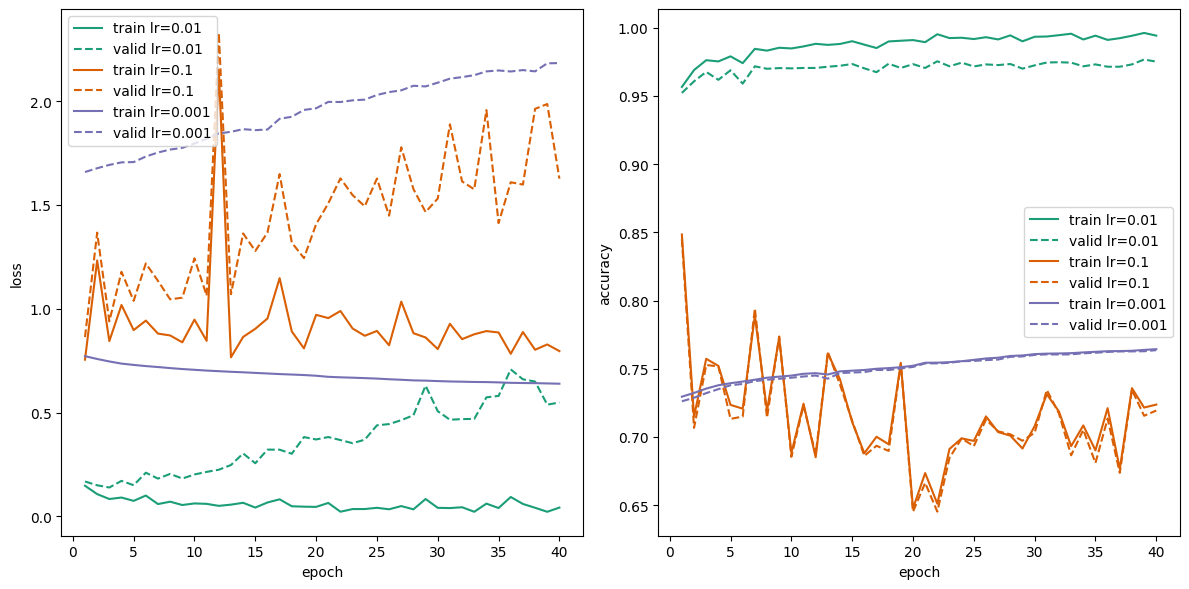

In [ ]:
from matplotlib import cm
fig,axes=plt.subplots(1,2)
fig.set_size_inches(12.0,6.0)
colors = cm.Dark2.colors
for color,learning_rate in zip(colors,df1["Lr"].unique()):
    dfn = df1[df1["Lr"]==learning_rate]
    x = dfn["epoch"]
    ax = axes[0]
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.plot(x+1,dfn["train_loss"],label=f"train lr={learning_rate}",color=color)
    ax.plot(x+1,dfn["valid_loss"],label=f"valid lr={learning_rate}",color=color,linestyle='--')
    ax.legend()
    ax = axes[1]
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.plot(x+1,dfn["train_accu"],label=f"train lr={learning_rate}",color=color)
    ax.plot(x+1,dfn["valid_accu"],label=f"valid lr={learning_rate}",color=color,linestyle='--')
    ax.legend()
fig.tight_layout()
plt.show()

## Entrenamiento modelo ManualDropOut().

In [ ]:
df_manual = pd.DataFrame()

In [ ]:
#modelo_manual = ManualDropOut(0.2,512)

In [ ]:
#modelo_manual.to(device)
df_manual = train_validation(model,train_loader,test_loader,df_manual)

lr=0.1 epoch=0 train_loss=0.9762465579232682 train_accu=0.7260333333333333 valid_loss=0.9867617831488323 valid_accu=0.728


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=1 train_loss=1.1730810626864687 train_accu=0.6166333333333334 valid_loss=1.1869166884452673 valid_accu=0.6198


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=2 train_loss=1.238036762867401 train_accu=0.5802666666666667 valid_loss=1.2529322956777682 valid_accu=0.5806


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=3 train_loss=1.1701895140889864 train_accu=0.59585 valid_loss=1.2275634168819258 valid_accu=0.5953


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=4 train_loss=1.2751854973942487 train_accu=0.5400833333333334 valid_loss=1.4372465861071446 valid_accu=0.5338


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=5 train_loss=1.2327855924553455 train_accu=0.5695166666666667 valid_loss=1.338466236166134 valid_accu=0.5669


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=6 train_loss=1.242462229690572 train_accu=0.5583833333333333 valid_loss=1.4884117978393652 valid_accu=0.5565


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=7 train_loss=1.3011565208435059 train_accu=0.5403666666666667 valid_loss=1.5216596494814394 valid_accu=0.5365


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=8 train_loss=1.4922503268540794 train_accu=0.5574166666666667 valid_loss=1.8119931949931345 valid_accu=0.5555


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=9 train_loss=1.131140777551289 train_accu=0.6297166666666667 valid_loss=1.4040800602572738 valid_accu=0.6336


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=10 train_loss=1.2940408295786965 train_accu=0.5256333333333333 valid_loss=1.5007737442186684 valid_accu=0.5226


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=11 train_loss=1.176749887496932 train_accu=0.6103 valid_loss=1.6594311291245138 valid_accu=0.6167


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=12 train_loss=1.1870634836047442 train_accu=0.5983833333333334 valid_loss=1.5392131854774087 valid_accu=0.593


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=13 train_loss=1.147274740977582 train_accu=0.60745 valid_loss=1.593751703477969 valid_accu=0.6033


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=14 train_loss=1.1613137776663562 train_accu=0.5859833333333333 valid_loss=1.4532586058993249 valid_accu=0.5789


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=15 train_loss=1.135832993524161 train_accu=0.5962333333333333 valid_loss=1.434981307026687 valid_accu=0.5955


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=16 train_loss=1.1163565592089695 train_accu=0.607 valid_loss=1.3648861739665838 valid_accu=0.6089


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=17 train_loss=1.0825718433490947 train_accu=0.6109666666666667 valid_loss=1.23023131964313 valid_accu=0.6156


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=18 train_loss=1.215863130430677 train_accu=0.5757833333333333 valid_loss=1.5542482608442854 valid_accu=0.5753


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=19 train_loss=1.3829096819419089 train_accu=0.60765 valid_loss=2.204115207787532 valid_accu=0.6104


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=20 train_loss=1.1738568029042755 train_accu=0.5962833333333334 valid_loss=1.566698436524458 valid_accu=0.5986


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=21 train_loss=1.2383293663896222 train_accu=0.6101666666666666 valid_loss=1.7674050452602896 valid_accu=0.6109


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=22 train_loss=1.0888752433409823 train_accu=0.6210833333333333 valid_loss=1.6712517985113107 valid_accu=0.6157


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=23 train_loss=1.1549984432741014 train_accu=0.59875 valid_loss=1.6096225549840624 valid_accu=0.5958


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=24 train_loss=1.2052700840460975 train_accu=0.59385 valid_loss=1.6993373264173033 valid_accu=0.5927


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=25 train_loss=1.0877166333864492 train_accu=0.60735 valid_loss=1.5881733017362607 valid_accu=0.6046


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=26 train_loss=1.116808080342787 train_accu=0.5897333333333333 valid_loss=1.5905198701627694 valid_accu=0.5876


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=27 train_loss=1.0956375911545906 train_accu=0.5945666666666667 valid_loss=1.564664787927251 valid_accu=0.5958


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=28 train_loss=1.1849469329629625 train_accu=0.5680833333333334 valid_loss=1.6848686470347605 valid_accu=0.5663


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=29 train_loss=1.1320460793941514 train_accu=0.5878666666666666 valid_loss=1.6357556000636642 valid_accu=0.583


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=30 train_loss=1.1414282244405767 train_accu=0.60575 valid_loss=1.987343770303544 valid_accu=0.605


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=31 train_loss=1.122372076328375 train_accu=0.5896333333333333 valid_loss=1.8391914751119673 valid_accu=0.5845


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=32 train_loss=1.1028809855614643 train_accu=0.5964166666666667 valid_loss=1.7912445436617372 valid_accu=0.5918


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=33 train_loss=1.0567325942043557 train_accu=0.62055 valid_loss=1.9033370371077472 valid_accu=0.6194


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=34 train_loss=1.1159444704238795 train_accu=0.58805 valid_loss=1.8348588746064787 valid_accu=0.5892


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=35 train_loss=1.158647731740846 train_accu=0.5940833333333333 valid_loss=1.884727325598905 valid_accu=0.5951


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=36 train_loss=1.1110376256234102 train_accu=0.59845 valid_loss=1.8979093128708517 valid_accu=0.5935


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=37 train_loss=1.1560200599592123 train_accu=0.5734666666666667 valid_loss=2.0032438802870973 valid_accu=0.5713


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=38 train_loss=1.1514701289790017 train_accu=0.5710833333333334 valid_loss=1.8328901631816936 valid_accu=0.5656


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.1 epoch=39 train_loss=1.0769611271713841 train_accu=0.6107 valid_loss=1.7264524690664498 valid_accu=0.6122


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=0 train_loss=0.15281750973580138 train_accu=0.9546833333333333 valid_loss=0.17546694450878247 valid_accu=0.9504


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=1 train_loss=0.13062881400534657 train_accu=0.9634833333333334 valid_loss=0.17709827644062365 valid_accu=0.955


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=2 train_loss=0.10062924548879322 train_accu=0.9707333333333333 valid_loss=0.14881245261054504 valid_accu=0.9606


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=3 train_loss=0.08333518865830036 train_accu=0.9759 valid_loss=0.1402884570877646 valid_accu=0.9641


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=4 train_loss=0.07424275930881548 train_accu=0.97885 valid_loss=0.15780554906128472 valid_accu=0.9645


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=5 train_loss=0.07962982415685245 train_accu=0.9781833333333333 valid_loss=0.15434183521287265 valid_accu=0.9685


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=6 train_loss=0.07661631525855815 train_accu=0.9784 valid_loss=0.17148455781765282 valid_accu=0.9661


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=7 train_loss=0.06161467891782142 train_accu=0.98325 valid_loss=0.16457334139644225 valid_accu=0.969


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=8 train_loss=0.06995199280353186 train_accu=0.9822 valid_loss=0.20566644347724547 valid_accu=0.9672


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=9 train_loss=0.0619366906664229 train_accu=0.98305 valid_loss=0.17355590948339278 valid_accu=0.9702


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=10 train_loss=0.0883530602599022 train_accu=0.9788166666666667 valid_loss=0.2380069905043369 valid_accu=0.963


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=11 train_loss=0.07119784276955873 train_accu=0.9812666666666666 valid_loss=0.2224823467831174 valid_accu=0.9656


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=12 train_loss=0.055184502221150525 train_accu=0.9858333333333333 valid_loss=0.18466188077327084 valid_accu=0.9717


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=13 train_loss=0.06181198255152011 train_accu=0.9836 valid_loss=0.2119112132510216 valid_accu=0.9695


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=14 train_loss=0.05326360129158065 train_accu=0.9864666666666667 valid_loss=0.23045618538935742 valid_accu=0.9703


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=15 train_loss=0.0673172927531198 train_accu=0.9844333333333334 valid_loss=0.25028890869381626 valid_accu=0.9674


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=16 train_loss=0.05298946733608188 train_accu=0.98575 valid_loss=0.2304627865853374 valid_accu=0.9718


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=17 train_loss=0.05102056907049227 train_accu=0.9871666666666666 valid_loss=0.23455993384141327 valid_accu=0.969


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=18 train_loss=0.04565010543954172 train_accu=0.9871333333333333 valid_loss=0.24712874245452804 valid_accu=0.9698


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=19 train_loss=0.04485540342045818 train_accu=0.9887 valid_loss=0.25629246417307155 valid_accu=0.969


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=20 train_loss=0.04429830659913494 train_accu=0.9888166666666667 valid_loss=0.22343312258966194 valid_accu=0.972


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=21 train_loss=0.04458239787022578 train_accu=0.9885166666666667 valid_loss=0.24240130466969645 valid_accu=0.9722


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=22 train_loss=0.048830098581930464 train_accu=0.9875166666666667 valid_loss=0.27571082000165853 valid_accu=0.9701


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=23 train_loss=0.05632877458011702 train_accu=0.9875166666666667 valid_loss=0.27295949686118115 valid_accu=0.9706


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=24 train_loss=0.04882566687959599 train_accu=0.98875 valid_loss=0.2819722012906365 valid_accu=0.9695


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=25 train_loss=0.042525673995767836 train_accu=0.9887666666666667 valid_loss=0.29805764434017434 valid_accu=0.9674


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=26 train_loss=0.058914442838990645 train_accu=0.9861666666666666 valid_loss=0.2635421173823759 valid_accu=0.9678


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=27 train_loss=0.040184417487625836 train_accu=0.99045 valid_loss=0.29650669034451055 valid_accu=0.9688


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=28 train_loss=0.042094981187196075 train_accu=0.9891833333333333 valid_loss=0.28392304353746445 valid_accu=0.9722


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=29 train_loss=0.036321400437609855 train_accu=0.99055 valid_loss=0.31187804441190503 valid_accu=0.9706


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=30 train_loss=0.045157849473606064 train_accu=0.98945 valid_loss=0.29660265228638816 valid_accu=0.9707


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=31 train_loss=0.0372285099636689 train_accu=0.9907333333333334 valid_loss=0.2936590791875198 valid_accu=0.9742


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=32 train_loss=0.040522751081151026 train_accu=0.9906666666666667 valid_loss=0.3105103788078186 valid_accu=0.9711


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=33 train_loss=0.05732299559925628 train_accu=0.9894333333333334 valid_loss=0.38194152367540696 valid_accu=0.97


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=34 train_loss=0.04201816306516657 train_accu=0.9907 valid_loss=0.32864994504246875 valid_accu=0.9735


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=35 train_loss=0.03598288198529979 train_accu=0.99105 valid_loss=0.348397442409918 valid_accu=0.9704


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=36 train_loss=0.04291591077836606 train_accu=0.99065 valid_loss=0.3123723932995214 valid_accu=0.972


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=37 train_loss=0.03451514983703221 train_accu=0.9920833333333333 valid_loss=0.3540859902205624 valid_accu=0.9716


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=38 train_loss=0.03429043915754299 train_accu=0.9916833333333334 valid_loss=0.29892851962425493 valid_accu=0.9721


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.01 epoch=39 train_loss=0.026104090390812344 train_accu=0.9933666666666666 valid_loss=0.32788235230634005 valid_accu=0.9719


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=0 train_loss=0.12046531167651799 train_accu=0.9655333333333334 valid_loss=0.12910666979054453 valid_accu=0.9612


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=1 train_loss=0.07408167280828648 train_accu=0.9788333333333333 valid_loss=0.08867672929291133 valid_accu=0.9726


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=2 train_loss=0.04939741810842324 train_accu=0.9852166666666666 valid_loss=0.07427812730085259 valid_accu=0.9769


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=3 train_loss=0.042932719260931756 train_accu=0.9862666666666666 valid_loss=0.07547974430160319 valid_accu=0.9748


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=4 train_loss=0.029958168268705142 train_accu=0.9910333333333333 valid_loss=0.06835446136971716 valid_accu=0.978


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=5 train_loss=0.020211292221384652 train_accu=0.99445 valid_loss=0.058487289208213646 valid_accu=0.9816


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=6 train_loss=0.01845086562516255 train_accu=0.9945833333333334 valid_loss=0.06584677450233925 valid_accu=0.9791


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=7 train_loss=0.013571527209316593 train_accu=0.9963333333333333 valid_loss=0.06113059845343614 valid_accu=0.9803


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=8 train_loss=0.013434677039876134 train_accu=0.9958833333333333 valid_loss=0.06107968036230654 valid_accu=0.9813


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=9 train_loss=0.009447125603428367 train_accu=0.9973666666666666 valid_loss=0.06523949894908815 valid_accu=0.9822


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=10 train_loss=0.010163404106937928 train_accu=0.9972166666666666 valid_loss=0.06843011386196043 valid_accu=0.9806


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=11 train_loss=0.006149750808148391 train_accu=0.9984166666666666 valid_loss=0.062479625808817704 valid_accu=0.9835


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=12 train_loss=0.005252143671194194 train_accu=0.9986166666666667 valid_loss=0.06285696456625026 valid_accu=0.9838


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=13 train_loss=0.006222964025647073 train_accu=0.9980166666666667 valid_loss=0.07422610947256982 valid_accu=0.9811


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=14 train_loss=0.004744404682534843 train_accu=0.9984666666666666 valid_loss=0.0680355182858545 valid_accu=0.9835


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=15 train_loss=0.00333809827328556 train_accu=0.9991 valid_loss=0.07273289200771574 valid_accu=0.9824


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=16 train_loss=0.004669277498051127 train_accu=0.9986 valid_loss=0.07593949838567991 valid_accu=0.9821


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=17 train_loss=0.004070358303798401 train_accu=0.9988 valid_loss=0.07833173373111836 valid_accu=0.983


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=18 train_loss=0.002910913862168232 train_accu=0.9991666666666666 valid_loss=0.07123479109712143 valid_accu=0.9838


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=19 train_loss=0.003073094359148848 train_accu=0.99905 valid_loss=0.08225094761866357 valid_accu=0.9806


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=20 train_loss=0.0033347879395695425 train_accu=0.999 valid_loss=0.08231679794013577 valid_accu=0.9817


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=21 train_loss=0.003645428680777577 train_accu=0.9987833333333334 valid_loss=0.08693228230611126 valid_accu=0.9807


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=22 train_loss=0.0027092337951429733 train_accu=0.9991666666666666 valid_loss=0.08473836079405342 valid_accu=0.9819


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=23 train_loss=0.0023186062526307063 train_accu=0.9993166666666666 valid_loss=0.08313188046418434 valid_accu=0.9829


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=24 train_loss=0.001091854960088937 train_accu=0.9997833333333334 valid_loss=0.07733970814257038 valid_accu=0.9832


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=25 train_loss=0.003179134352313786 train_accu=0.9989333333333333 valid_loss=0.08366397457516643 valid_accu=0.9834


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=26 train_loss=0.0018032481029304414 train_accu=0.9994666666666666 valid_loss=0.0836268911439474 valid_accu=0.9829


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=27 train_loss=0.0018337404966374674 train_accu=0.9994666666666666 valid_loss=0.07655353077101487 valid_accu=0.9844


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=28 train_loss=0.0028839069363720093 train_accu=0.9990333333333333 valid_loss=0.0885367046635592 valid_accu=0.983


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=29 train_loss=0.0024146003441204303 train_accu=0.9992666666666666 valid_loss=0.09388497410625439 valid_accu=0.9824


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=30 train_loss=0.0026256546719769236 train_accu=0.9990666666666667 valid_loss=0.0927292312975205 valid_accu=0.9823


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=31 train_loss=0.003977620999194248 train_accu=0.9985166666666667 valid_loss=0.09244413904134567 valid_accu=0.9821


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=32 train_loss=0.0006425431365570944 train_accu=0.9999 valid_loss=0.0906548109416217 valid_accu=0.9836


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=33 train_loss=0.0009026600577215413 train_accu=0.9997833333333334 valid_loss=0.08719952861220026 valid_accu=0.9832


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=34 train_loss=0.0023127768097414543 train_accu=0.99915 valid_loss=0.10167587986278573 valid_accu=0.9823


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=35 train_loss=0.0014496526880023453 train_accu=0.9994666666666666 valid_loss=0.10168048325917552 valid_accu=0.9831


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=36 train_loss=0.003059250965063455 train_accu=0.9989166666666667 valid_loss=0.10452808530194152 valid_accu=0.9833


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=37 train_loss=0.002109143215276937 train_accu=0.9992833333333333 valid_loss=0.09627710356221804 valid_accu=0.9841


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=38 train_loss=0.0014958024369306508 train_accu=0.9994666666666666 valid_loss=0.09343557034983598 valid_accu=0.9844


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


lr=0.001 epoch=39 train_loss=0.002081040918388958 train_accu=0.99945 valid_loss=0.12051451291276487 valid_accu=0.9821


<ipython-input-22-89706fee0790>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Lr":learning_rate,


In [ ]:
df3 = df_manual.pivot_table(index=["Lr","epoch"],aggfunc="mean").reset_index()
#df3

<ipython-input-43-959677f63db5>:1: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  df3 = df_manual.pivot_table(index=["Lr","epoch"],aggfunc="mean").reset_index()


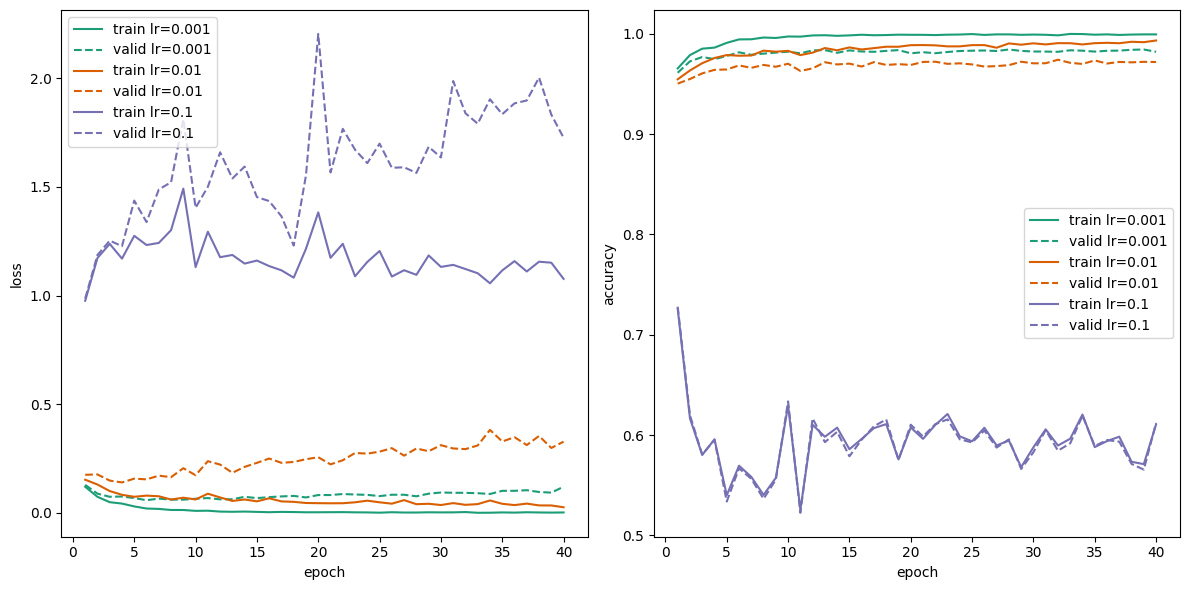

In [ ]:
from matplotlib import cm
fig,axes=plt.subplots(1,2)
fig.set_size_inches(12.0,6.0)
colors = cm.Dark2.colors
for color,learning_rate in zip(colors,df3["Lr"].unique()):
    dfn = df3[df3["Lr"]==learning_rate]
    x = dfn["epoch"]
    ax = axes[0]
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.plot(x+1,dfn["train_loss"],label=f"train lr={learning_rate}",color=color)
    ax.plot(x+1,dfn["valid_loss"],label=f"valid lr={learning_rate}",color=color,linestyle='--')
    ax.legend()
    ax = axes[1]
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.plot(x+1,dfn["train_accu"],label=f"train lr={learning_rate}",color=color)
    ax.plot(x+1,dfn["valid_accu"],label=f"valid lr={learning_rate}",color=color,linestyle='--')
    ax.legend()
fig.tight_layout()
plt.show()

## Pytorch's Dropout 

In [ ]:
df_dropout = pd.DataFrame()
df_dropout = train_validation(model,train_loader,test_loader,df_dropout)

NameError: ignored

In [ ]:
df2 = df_dropout.pivot_table(index=["Lr","epoch"],aggfunc="mean").reset_index()

In [ ]:
fig,axes=plt.subplots(1,2)
fig.set_size_inches(12.0,6.0)
colors = cm.Dark2.colors
for color,learning_rate in zip(colors,df2["Lr"].unique()):
    dfn = df2[df2["Lr"]==learning_rate]
    x = dfn["epoch"]
    ax = axes[0]
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.plot(x+1,dfn["train_loss"],label=f"train lr={learning_rate}",color=color)
    ax.plot(x+1,dfn["valid_loss"],label=f"valid lr={learning_rate}",color=color,linestyle='--')
    ax.legend()
    ax = axes[1]
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.plot(x+1,dfn["train_accu"],label=f"train lr={learning_rate}",color=color)
    ax.plot(x+1,dfn["valid_accu"],label=f"valid lr={learning_rate}",color=color,linestyle='--')
    ax.legend()
fig.tight_layout()
plt.show()